In [1]:
import pandas as pd

# 加载数据
X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
y_train = pd.read_csv("../data/y_train.csv", skiprows=1, header=None)

# 转为 NumPy
X = X_train.values                # shape: (10000, 300)
y = y_train.values.ravel()       # shape: (10000,)


In [2]:
print(f"The size of data is {X.shape[0]}")
print(f"The number of features of each sample is {X.shape[1]}")

The size of data is 10000
The number of features of each sample is 300


### 缺失值检测

In [3]:
import numpy as np

print(f"Feature missing values: {np.isnan(X).sum()}")
print(f"Label missing values: {np.isnan(y).sum()}")


Feature missing values: 0
Label missing values: 0


## 特征选择

### 每对类别对应的 Top-K 区分性特征信息（按均值差排序）

In [4]:
import numpy as np
from itertools import combinations

class_list = np.unique(y)
class_pairs = list(combinations(class_list, 2))

pairwise_topk = {}
k = 10  # 控制 top-K 

for cls0, cls1 in class_pairs:
    idx0 = (y == cls0)
    idx1 = (y == cls1)
    
    # 计算class0和class1的特征均值差异
    mean0 = X[idx0].mean(axis=0)
    mean1 = X[idx1].mean(axis=0)
    diff = np.abs(mean0 - mean1)
    
    # 对特征差异进行排序
    topk_idx = np.argsort(diff)[::-1][:k]  

    feature_info = []
    for rank, feat_idx in enumerate(topk_idx):
        feature_info.append({
            "feature_idx": int(feat_idx),
            "mean_diff": float(diff[feat_idx]),
            "rank": rank + 1
        })

    pairwise_topk[(int(cls0), int(cls1))] = feature_info


In [5]:
for pair in list(pairwise_topk.keys()):
    print(f"\nClass Pair: {pair}")
    for feat in pairwise_topk[pair]:
        print(f"  F{feat['feature_idx']}: mean_diff = {feat['mean_diff']:.4f}")



Class Pair: (0, 1)
  F131: mean_diff = 2.3882
  F35: mean_diff = 1.9080
  F85: mean_diff = 1.8621
  F223: mean_diff = 1.8311
  F200: mean_diff = 1.8172
  F184: mean_diff = 1.8020
  F148: mean_diff = 1.7221
  F222: mean_diff = 1.7164
  F42: mean_diff = 1.6864
  F204: mean_diff = 1.6783

Class Pair: (0, 2)
  F55: mean_diff = 1.9008
  F186: mean_diff = 1.8883
  F208: mean_diff = 1.8279
  F53: mean_diff = 1.5811
  F123: mean_diff = 1.5511
  F240: mean_diff = 1.4859
  F242: mean_diff = 1.4702
  F125: mean_diff = 1.4607
  F44: mean_diff = 1.4404
  F293: mean_diff = 1.4218

Class Pair: (0, 3)
  F210: mean_diff = 1.2958
  F53: mean_diff = 1.2275
  F21: mean_diff = 1.1430
  F55: mean_diff = 1.0952
  F278: mean_diff = 1.0869
  F284: mean_diff = 1.0657
  F254: mean_diff = 1.0295
  F137: mean_diff = 0.9544
  F288: mean_diff = 0.9502
  F216: mean_diff = 0.9390

Class Pair: (0, 4)
  F53: mean_diff = 1.6164
  F22: mean_diff = 1.5048
  F213: mean_diff = 1.3916
  F291: mean_diff = 1.3072
  F91: mean_d


Top 10 most frequently selected features across class pairs:
     feature_idx  count
96           279     68
0            131     66
2             85     56
52            79     49
83            17     49
15           240     49
140          270     48
10            55     47
54           259     46
46           182     44


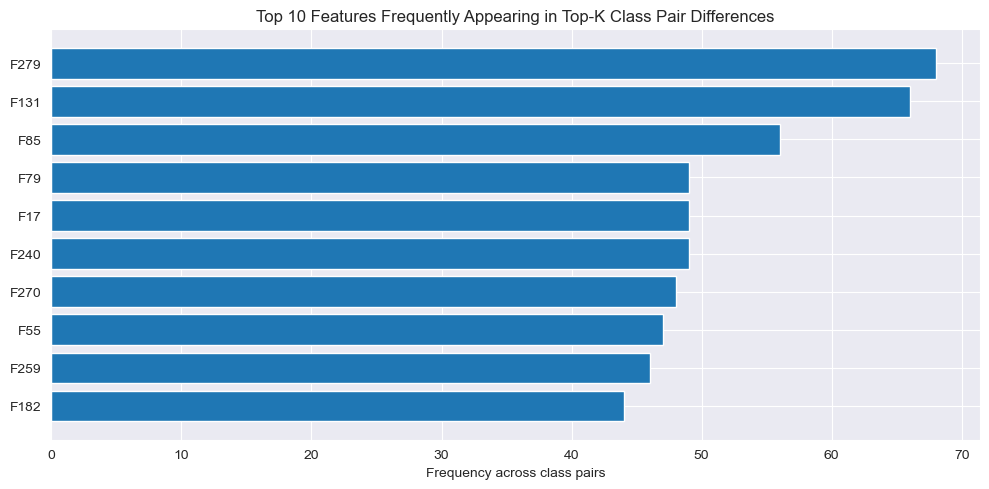

In [6]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 收集所有特征索引
all_topk_feats = []
for pair in pairwise_topk.values():
    all_topk_feats.extend([f['feature_idx'] for f in pair])

# 统计出现频次
feat_counter = Counter(all_topk_feats)

# 转为 DataFrame 
feat_freq_df = pd.DataFrame(feat_counter.items(), columns=["feature_idx", "count"])
feat_freq_df.sort_values(by="count", ascending=False, inplace=True)

# 前10个最常出现的特征
print("\nTop 10 most frequently selected features across class pairs:")
print(feat_freq_df.head(10))

# 柱状图可视化
top_n = 10
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in feat_freq_df["feature_idx"].head(top_n)][::-1],
    feat_freq_df["count"].head(top_n)[::-1]
)
plt.xlabel("Frequency across class pairs")
plt.title(f"Top {top_n} Features Frequently Appearing in Top-K Class Pair Differences")
plt.tight_layout()
plt.show()


### 基于 p-value 的 pairwise 特征分析

In [7]:
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

# 初始化
class_list = np.unique(y)
class_pairs = list(combinations(class_list, 2))

pairwise_topk_pval = {}
k = 10  # 控制 top-K

for cls0, cls1 in class_pairs:
    idx0 = (y == cls0)
    idx1 = (y == cls1)

    # 对每个特征进行 t-test
    p_values = []
    for i in range(X.shape[1]):
        stat, p = ttest_ind(X[idx0, i], X[idx1, i], equal_var=False)
        p_values.append(p)

    p_values = np.array(p_values)

    # 取前 k 个最显著（p 值最小）的特征
    topk_idx = np.argsort(p_values)[:k]

    feature_info = []
    for rank, feat_idx in enumerate(topk_idx):
        feature_info.append({
            "feature_idx": int(feat_idx),
            "p_value": float(p_values[feat_idx]),
            "rank": rank + 1
        })

    pairwise_topk_pval[(int(cls0), int(cls1))] = feature_info


In [8]:
for pair in list(pairwise_topk_pval.keys()):
    print(f"\nClass Pair: {pair}")
    for feat in pairwise_topk_pval[pair]:
        print(f"  F{feat['feature_idx']}: p_value = {feat['p_value']:.4e}")



Class Pair: (0, 1)
  F215: p_value = 7.2119e-06
  F131: p_value = 1.0586e-05
  F49: p_value = 1.0922e-05
  F46: p_value = 4.3906e-05
  F43: p_value = 5.1901e-05
  F216: p_value = 8.0268e-05
  F35: p_value = 1.3457e-04
  F85: p_value = 2.1428e-04
  F41: p_value = 3.1122e-04
  F191: p_value = 3.8586e-04

Class Pair: (0, 2)
  F55: p_value = 1.6105e-05
  F208: p_value = 1.9026e-05
  F158: p_value = 1.3723e-04
  F270: p_value = 1.4763e-04
  F44: p_value = 1.5858e-04
  F213: p_value = 3.5389e-04
  F123: p_value = 4.8544e-04
  F242: p_value = 6.2168e-04
  F216: p_value = 7.4613e-04
  F60: p_value = 1.0061e-03

Class Pair: (0, 3)
  F55: p_value = 1.8989e-06
  F21: p_value = 9.5715e-06
  F288: p_value = 7.3358e-05
  F210: p_value = 2.2186e-04
  F223: p_value = 2.4664e-04
  F97: p_value = 2.6029e-04
  F166: p_value = 2.9106e-04
  F278: p_value = 4.5712e-04
  F146: p_value = 5.0511e-04
  F283: p_value = 6.9075e-04

Class Pair: (0, 4)
  F22: p_value = 5.4815e-07
  F199: p_value = 7.1720e-07
  F29


Top 10 most frequently selected features across class pairs (by t-test p-value):
    feature_idx  count
43           17     93
13          270     85
90          279     62
55           79     58
39           90     58
36          218     56
45           71     53
5           216     47
62          265     47
10           55     46


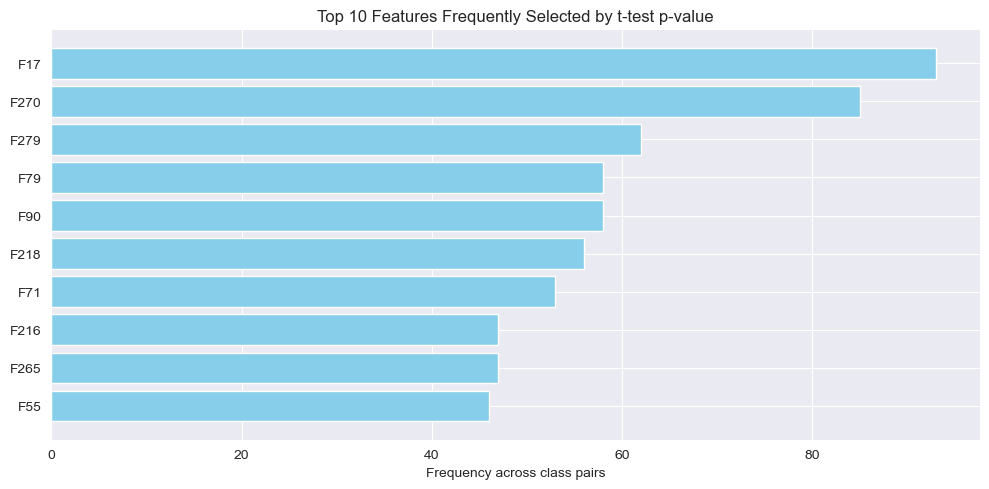

In [9]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 收集所有特征索引
all_topk_feats_pval = []
for pair in pairwise_topk_pval.values():
    all_topk_feats_pval.extend([f['feature_idx'] for f in pair])

# 统计出现频次
feat_counter_pval = Counter(all_topk_feats_pval)

# 转为 DataFrame
feat_freq_df_pval = pd.DataFrame(feat_counter_pval.items(), columns=["feature_idx", "count"])
feat_freq_df_pval.sort_values(by="count", ascending=False, inplace=True)

# 前10个最常出现的特征
print("\nTop 10 most frequently selected features across class pairs (by t-test p-value):")
print(feat_freq_df_pval.head(10))

top_n = 10
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in feat_freq_df_pval["feature_idx"].head(top_n)][::-1],
    feat_freq_df_pval["count"].head(top_n)[::-1],
    color="skyblue"
)
plt.xlabel("Frequency across class pairs")
plt.title(f"Top {top_n} Features Frequently Selected by t-test p-value")
plt.tight_layout()
plt.show()



### 基于Mutual Information 的 全局 分析 

单次对整体 X vs y，每个特征对全体标签的 MI，哪些特征整体上最有用

In [10]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# 计算所有特征与标签的 MI 分数
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 构建完整 DataFrame（所有特征）
feat_mi_global_df = pd.DataFrame({
    "feature_idx": np.arange(len(mi_scores)),
    "mi_global_score": mi_scores 
})

# 按分数从高到低排序
feat_mi_global_df.sort_values(by="mi_global_score", ascending=False, inplace=True)

# 展示前几行
print("\nMutual Information Full Feature Table (for fusion):")
print(feat_mi_global_df.head(10))



Mutual Information Full Feature Table (for fusion):
     feature_idx  mi_global_score
48            48         0.318193
270          270         0.304972
17            17         0.301547
263          263         0.275074
90            90         0.269411
172          172         0.266451
231          231         0.258278
283          283         0.251765
88            88         0.250956
71            71         0.238814


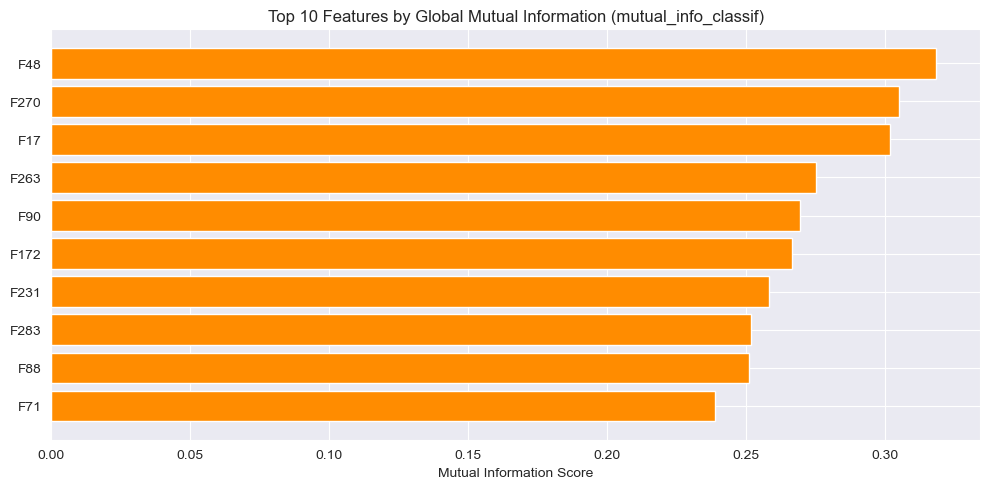

In [11]:
import matplotlib.pyplot as plt

top_k = 10
top_mi = feat_mi_global_df.head(top_k)

plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in top_mi["feature_idx"]][::-1],
    top_mi["mi_global_score"][::-1],
    color="darkorange"
)
plt.xlabel("Mutual Information Score")
plt.title(f"Top {top_k} Features by Global Mutual Information (mutual_info_classif)")
plt.tight_layout()
plt.show()


### 基于Mutual Information 的 pairwise 分析 


对每个类别对 (i,j) 做子集的 MI，哪些特征在局部类别对中区分强

In [12]:
from sklearn.feature_selection import mutual_info_classif
from itertools import combinations

class_pairs = list(combinations(np.unique(y), 2))
pairwise_topk_mi = {}

for cls0, cls1 in class_pairs:
    idx = (y == cls0) | (y == cls1)
    X_sub = X[idx]
    y_sub = y[idx]
    
    mi_scores = mutual_info_classif(X_sub, y_sub, discrete_features=False, random_state=42)
    topk_idx = np.argsort(mi_scores)[::-1][:k]

    feature_info = []
    for rank, feat_idx in enumerate(topk_idx):
        feature_info.append({
            "feature_idx": int(feat_idx),
            "mi_score": float(mi_scores[feat_idx]),
            "rank": rank + 1
        })

    pairwise_topk_mi[(int(cls0), int(cls1))] = feature_info



Top 10 most frequently selected features across class pairs (by mutual information):
     feature_idx  count
14           270     88
46            17     83
40            90     71
34           218     65
107          279     64
53            79     55
37           265     51
10            55     51
90           268     51
39            87     48


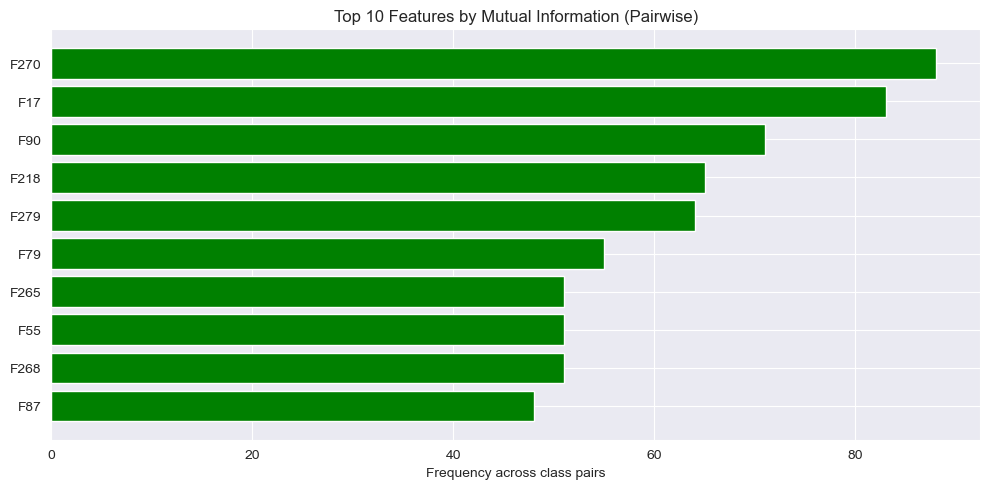

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# 统计所有出现过的特征频次
all_topk_feats_mi = []
for pair in pairwise_topk_mi.values():
    all_topk_feats_mi.extend([f['feature_idx'] for f in pair])

feat_counter_mi = Counter(all_topk_feats_mi)
feat_mi_pairwise_df = pd.DataFrame(feat_counter_mi.items(), columns=["feature_idx", "count"])
feat_mi_pairwise_df.sort_values(by="count", ascending=False, inplace=True)

# 前10个最常出现的特征
print("\nTop 10 most frequently selected features across class pairs (by mutual information):")
print(feat_mi_pairwise_df.head(10))

# 可视化
top_n = 10
plt.figure(figsize=(10, 5))
plt.barh(
    [f"F{int(i)}" for i in feat_mi_pairwise_df["feature_idx"].head(top_n)][::-1],
    feat_mi_pairwise_df["count"].head(top_n)[::-1],
    color="green"
)
plt.xlabel("Frequency across class pairs")
plt.title(f"Top {top_n} Features by Mutual Information (Pairwise)")
plt.tight_layout()
plt.show()


### 特征融合

In [14]:
# 标准化列名 重命名所有列，保持统一
feat_freq_df = feat_freq_df.rename(columns={"count": "freq_mean"})
feat_freq_df_pval = feat_freq_df_pval.rename(columns={"count": "freq_pval"})
feat_mi_pairwise_df = feat_mi_pairwise_df.rename(columns={"count": "freq_mi_pairwise"})
feat_mi_global_df = feat_mi_global_df.rename(columns={"mi_global_score": "freq_mi_global"})


In [15]:
# 合并所有特征选择结果
from functools import reduce

# 用 feature_idx 作为主键进行 outer 合并
dfs = [feat_freq_df, feat_freq_df_pval, feat_mi_pairwise_df, feat_mi_global_df]
feat_merged = reduce(lambda left, right: pd.merge(left, right, on="feature_idx", how="outer"), dfs)

# 空值填 0（即某方法未选中）
feat_merged.fillna(0, inplace=True)


In [16]:
# 合并所有特征选择结果
from functools import reduce

# 用 feature_idx 作为主键进行 outer 合并
dfs = [feat_freq_df, feat_freq_df_pval, feat_mi_pairwise_df, feat_mi_global_df]
feat_merged = reduce(lambda left, right: pd.merge(left, right, on="feature_idx", how="outer"), dfs)

# 空值填 0（即某方法未选中）
feat_merged.fillna(0, inplace=True)


In [17]:
## 方法一：Rank 平均融合
# 对每一列进行排名（值越大排名越靠前）
feat_merged["rank_mean"] = feat_merged["freq_mean"].rank(ascending=False)
feat_merged["rank_pval"] = feat_merged["freq_pval"].rank(ascending=False)
feat_merged["rank_mi_pairwise"] = feat_merged["freq_mi_pairwise"].rank(ascending=False)
feat_merged["rank_mi_global"] = feat_merged["freq_mi_global"].rank(ascending=False)

# 综合评分（可调权重）
feat_merged["rank_avg"] = (
    feat_merged["rank_mean"] +
    feat_merged["rank_pval"] +
    feat_merged["rank_mi_pairwise"] +
    feat_merged["rank_mi_global"]
) / 4

# 排序输出
feat_merged.sort_values(by="rank_avg", inplace=True)


In [19]:
## 方法二：投票机制（至少出现在多少种方法中）
feat_merged["vote_count"] = (
    (feat_merged["freq_mean"] > 0).astype(int) +
    (feat_merged["freq_pval"] > 0).astype(int) +
    (feat_merged["freq_mi_pairwise"] > 0).astype(int) +
    (feat_merged["freq_mi_global"] > 0).astype(int)
)


In [22]:
# 最终选出 Top-K 特征
top_k = 100
final_features = feat_merged["feature_idx"].head(top_k).astype(int).tolist()

# 可视输出
print(f"\nFinal Selected Top-{top_k} Features (Fused)")
print(feat_merged[["feature_idx", "rank_avg", "vote_count"]].head(top_k))



Final Selected Top-100 Features (Fused)
     feature_idx  rank_avg  vote_count
17            17     2.750           4
270          270     3.000           4
218          218    10.250           4
90            90    11.750           4
265          265    15.500           4
..           ...       ...         ...
287          287   110.250           4
21            21   112.375           4
116          116   112.750           4
261          261   113.750           4
159          159   113.750           4

[100 rows x 3 columns]


### 评估特征

In [38]:
## 互信息解释比 累计
import numpy as np

def plot_cumulative_information(feat_merged, mi_scores, top_k=100):
    """
    画出融合特征排序下前 N 个特征的累计互信息解释比。
    """
    # 1. 取前 top_k 的特征索引（已排序）
    feat_merged_sorted = feat_merged.sort_values(by="rank_avg")
    selected_indices = feat_merged_sorted["feature_idx"].tolist()[:top_k]

    # 2. 计算累计互信息
    cumulative_info = np.cumsum([mi_scores[i] for i in selected_indices])
    total_info = np.sum(mi_scores)
    explained_ratio = cumulative_info / total_info

    # 3. 打印一些 Top-N 的解释率
    print("\nCumulative Mutual Information Explained:")
    for n in [10, 20, 30, 50, 100, 150, 200, 250]:
        if n <= len(explained_ratio):
            print(f"  Top-{n:>3}: {explained_ratio[n-1]:.2%} of total MI")

    # 4. 可视化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, top_k + 1), explained_ratio, marker='o', color='steelblue')
    plt.xlabel("Top-N Features (by fused rank)")
    plt.ylabel("Cumulative Mutual Information Ratio")
    plt.title("Cumulative Information Explained by Top-N Features")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return None



Cumulative Mutual Information Explained:
  Top- 10: 8.01% of total MI
  Top- 20: 15.29% of total MI
  Top- 30: 21.92% of total MI
  Top- 50: 31.85% of total MI
  Top-100: 52.00% of total MI
  Top-150: 68.32% of total MI
  Top-200: 82.55% of total MI
  Top-250: 93.16% of total MI


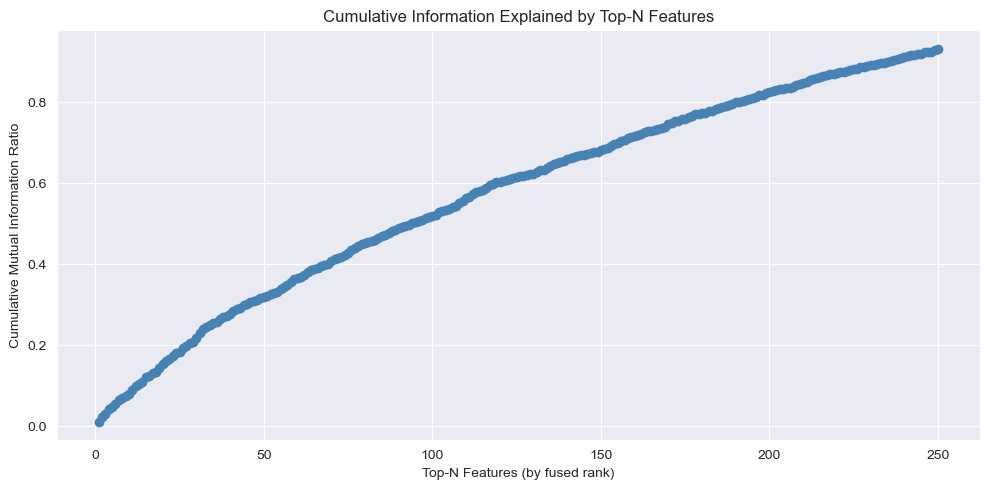

In [39]:
# 计算全局 MI 分数
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 默认 Top 100
plot_cumulative_information(feat_merged, mi_scores, top_k=250)


E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Ana

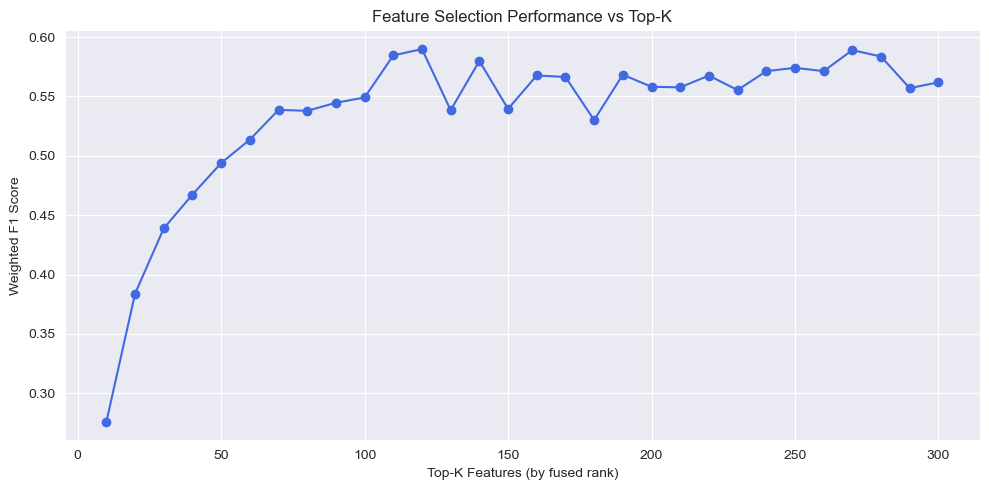

In [42]:
## Weighted F1-score

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 准备数据
X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y_train = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
X_test_2 = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).values
y_test_2 = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()
X_test_eval = X_test_2[:202]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_eval)

# 获取融合排序后的特征列表（最多前300个）
max_k = 300
sorted_features = feat_merged.sort_values(by="rank_avg")["feature_idx"].astype(int).tolist()[:max_k]

# 逐步评估不同 top-K 的性能
k_list = list(range(10, max_k + 1, 10))  # 从10开始每10步，避免0或过密
f1_scores = []

for k in k_list:
    selected_feats = sorted_features[:k]
    X_train_k = X_train_scaled[:, selected_feats]
    X_test_k = X_test_scaled[:, selected_feats]

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=28,
        eval_metric="mlogloss",
        use_label_encoder=False,
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train_k, y_train)
    y_pred = model.predict(X_test_k)

    f1 = f1_score(y_test_2, y_pred, average="weighted")
    f1_scores.append(f1)

plt.figure(figsize=(10, 5))
plt.plot(k_list, f1_scores, marker="o", color="royalblue")
plt.xlabel("Top-K Features (by fused rank)")
plt.ylabel("Weighted F1 Score")
plt.title("Feature Selection Performance vs Top-K")
plt.grid(True)
plt.tight_layout()
plt.show()


## 类别不均衡所带来的影响 和 缓解措施 

E:\Languages\Anaconda3\envs\py310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\p

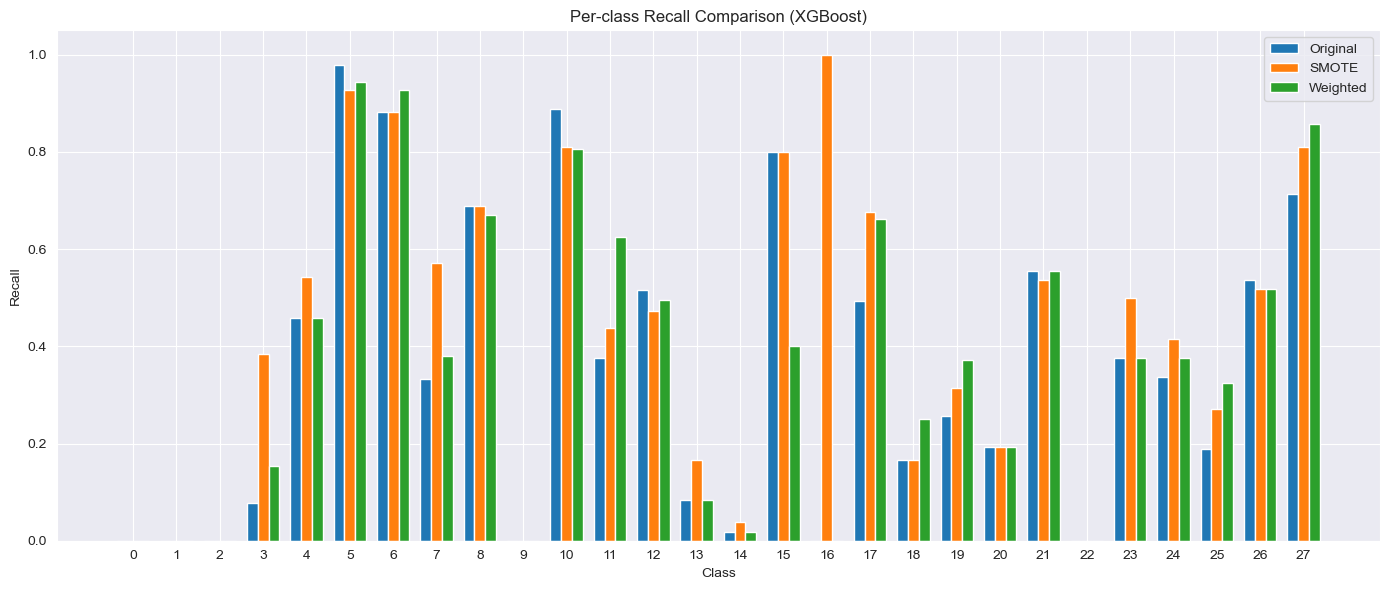

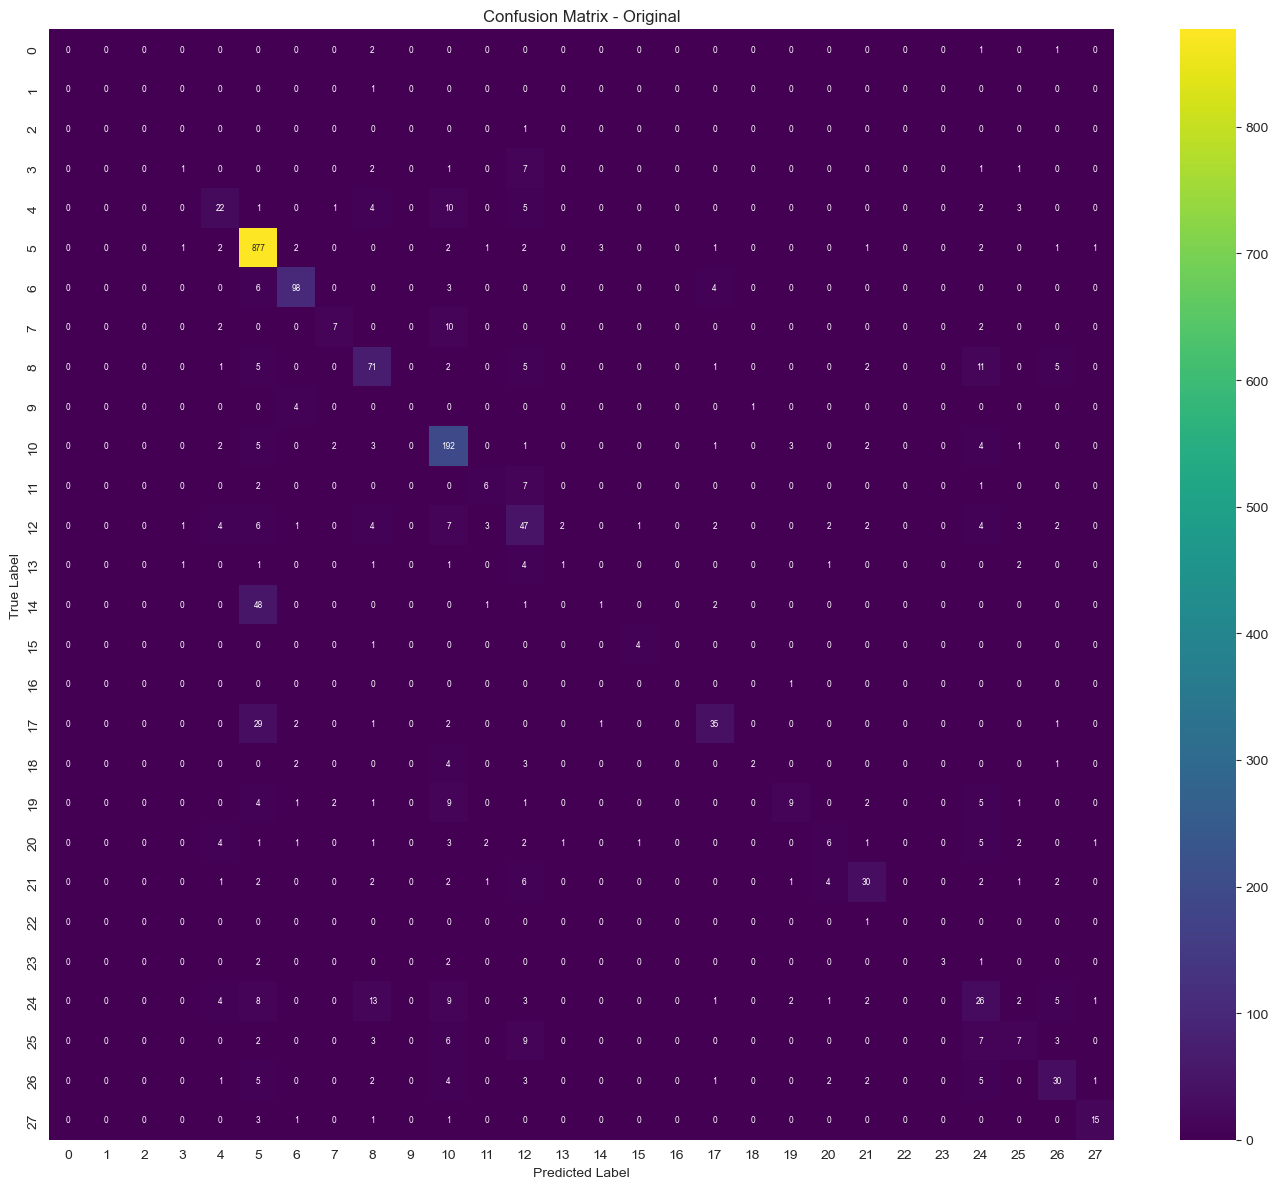

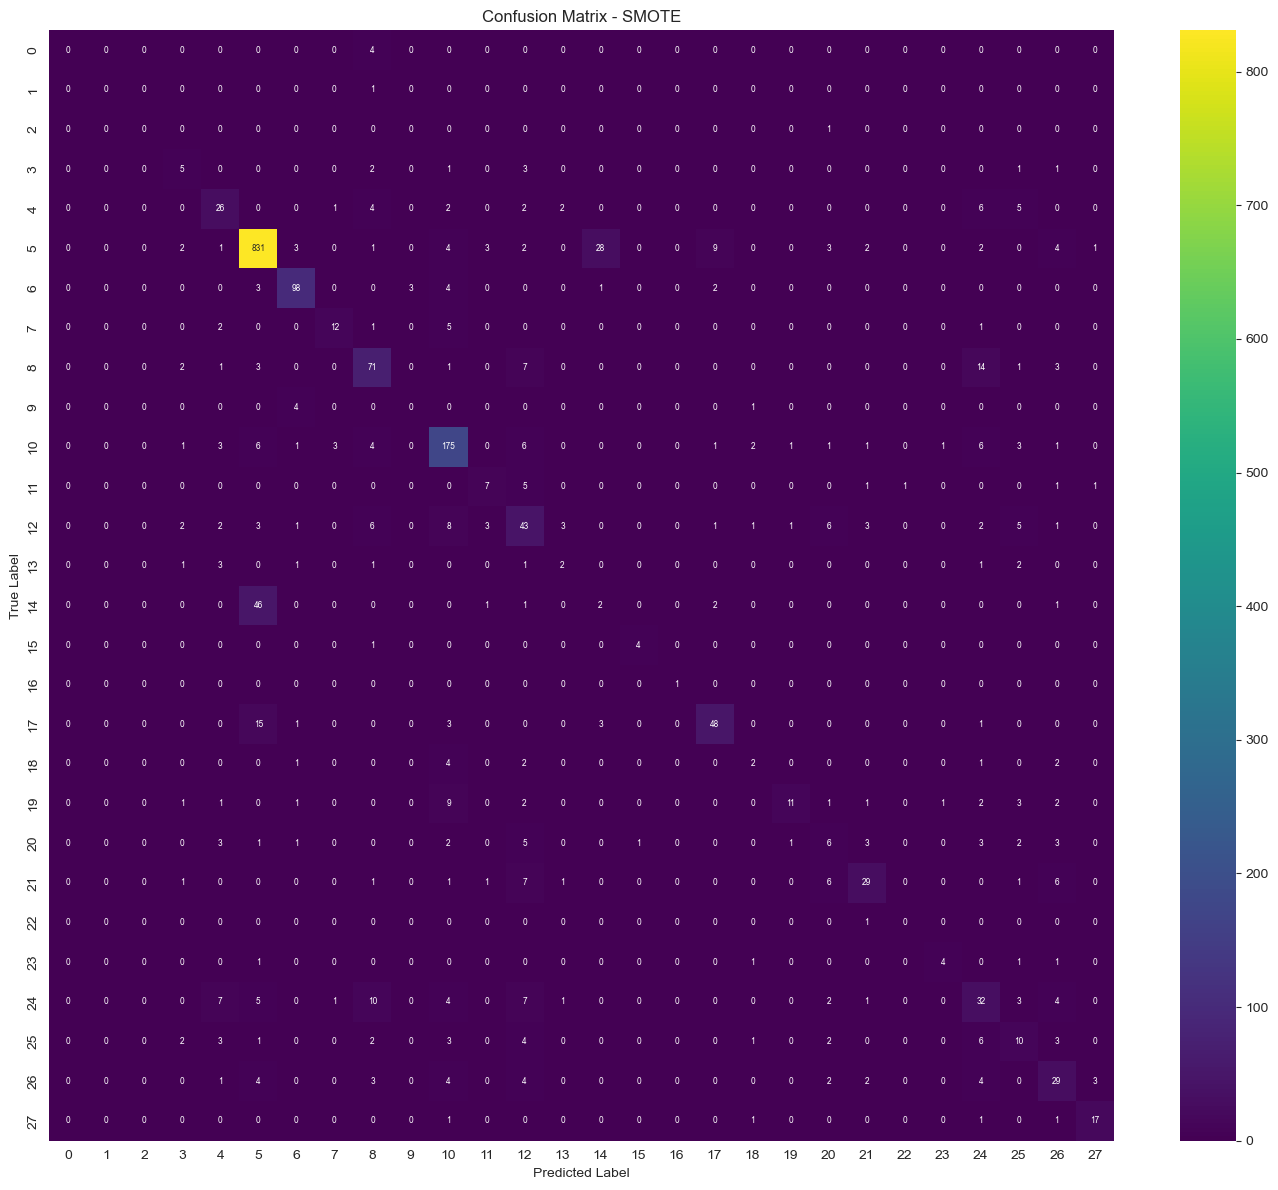

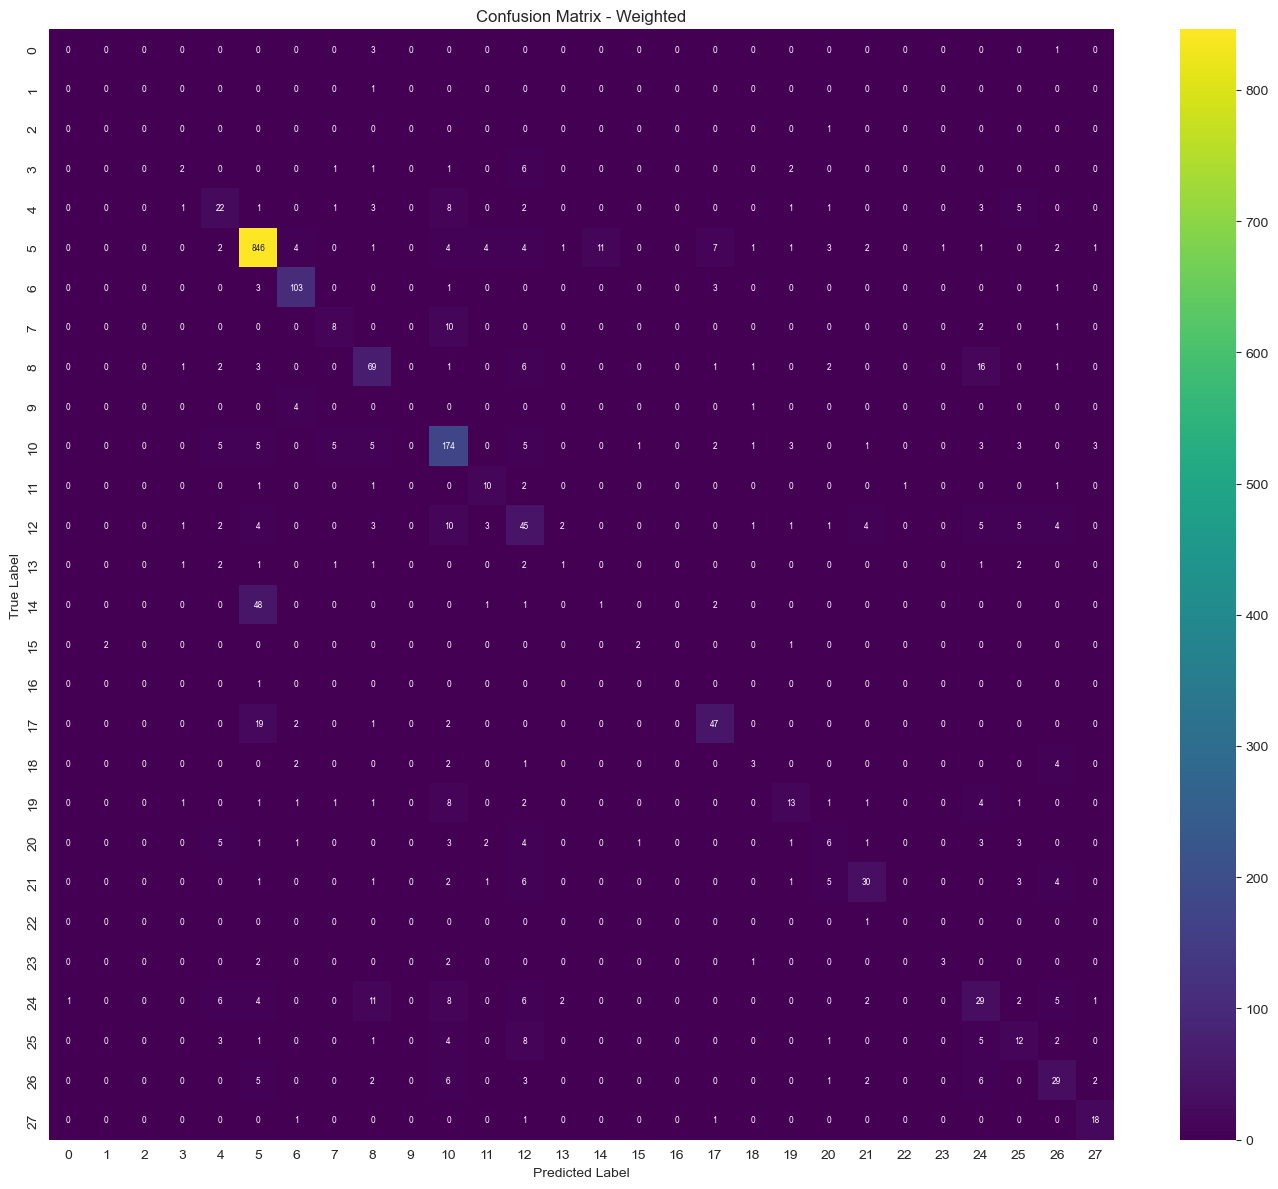

    Class  Original     SMOTE  Weighted
0       0  0.000000  0.000000  0.000000
1       1  0.000000  0.000000  0.000000
2       2  0.000000  0.000000  0.000000
3       3  0.076923  0.384615  0.153846
4       4  0.458333  0.541667  0.458333
5       5  0.978795  0.927455  0.944196
6       6  0.882883  0.882883  0.927928
7       7  0.333333  0.571429  0.380952
8       8  0.689320  0.689320  0.669903
9       9  0.000000  0.000000  0.000000
10     10  0.888889  0.810185  0.805556
11     11  0.375000  0.437500  0.625000
12     12  0.516484  0.472527  0.494505
13     13  0.083333  0.166667  0.083333
14     14  0.018868  0.037736  0.018868
15     15  0.800000  0.800000  0.400000
16     16  0.000000  1.000000  0.000000
17     17  0.492958  0.676056  0.661972
18     18  0.166667  0.166667  0.250000
19     19  0.257143  0.314286  0.371429
20     20  0.193548  0.193548  0.193548
21     21  0.555556  0.537037  0.555556
22     22  0.000000  0.000000  0.000000
23     23  0.375000  0.500000  0.375000


In [83]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

X_train_all = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y_train_raw = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

le = LabelEncoder()
y_all = le.fit_transform(y_train_raw)

X_subtrain_all, X_val_all, y_subtrain, y_val = train_test_split(
    X_train_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 使用前 100 个特征
final_features = feat_merged.sort_values(by="rank_avg")["feature_idx"].head(100).astype(int).tolist()
X_subtrain = X_subtrain_all[:, final_features]
X_val = X_val_all[:, final_features]

scaler = StandardScaler()
X_subtrain_std = scaler.fit_transform(X_subtrain)
X_val_std = scaler.transform(X_val)

# SMOTE 配置
min_samples = min(Counter(y_subtrain).values())
k = max(1, min(min_samples - 1, 5))
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_subtrain_std, y_subtrain)

# 类权重计算
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_subtrain), y=y_subtrain)
class_weights = dict(zip(np.unique(y_subtrain), weights))
sample_weights = np.array([class_weights[label] for label in y_subtrain])

# A. 原始训练
model_a = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_a.fit(X_subtrain_std, y_subtrain)
y_pred_a = model_a.predict(X_val_std)

# B. SMOTE
model_b = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_b.fit(X_smote, y_smote)
y_pred_b = model_b.predict(X_val_std)

# C. 类权重训练
model_c = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_c.fit(X_subtrain_std, y_subtrain, sample_weight=sample_weights)
y_pred_c = model_c.predict(X_val_std)

# 指标计算
results_xgb = {
    "A.Original": f1_score(y_val, y_pred_a, average="weighted"),
    "B.SMOTE": f1_score(y_val, y_pred_b, average="weighted"),
    "C.Weighted": f1_score(y_val, y_pred_c, average="weighted"),
}

# 每类 recall 比较
recall_df = pd.DataFrame({
    "Class": np.arange(28),
    "Original": recall_score(y_val, y_pred_a, average=None, zero_division=0),
    "SMOTE": recall_score(y_val, y_pred_b, average=None, zero_division=0),
    "Weighted": recall_score(y_val, y_pred_c, average=None, zero_division=0),
})

# 混淆矩阵函数
def plot_conf_matrix(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize=None, labels=np.arange(28))
    plt.figure(figsize=(14, 12))  
    sns.heatmap(cm, 
                annot=True, 
                fmt=".0f",         # 显示整数
                cmap="viridis", 
                annot_kws={"size": 6}, 
                xticklabels=np.arange(28), 
                yticklabels=np.arange(28))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# 柱状图比较 Recall
plt.figure(figsize=(14, 6))
x = np.arange(len(recall_df))
width = 0.25
plt.bar(x - width, recall_df["Original"], width=width, label="Original")
plt.bar(x, recall_df["SMOTE"], width=width, label="SMOTE")
plt.bar(x + width, recall_df["Weighted"], width=width, label="Weighted")
plt.xticks(ticks=x, labels=recall_df["Class"])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Per-class Recall Comparison (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# 混淆矩阵
plot_conf_matrix("Confusion Matrix - Original", y_val, y_pred_a)
plot_conf_matrix("Confusion Matrix - SMOTE", y_val, y_pred_b)
plot_conf_matrix("Confusion Matrix - Weighted", y_val, y_pred_c)

report_original = pd.DataFrame(classification_report(y_val, y_pred_a, output_dict=True, zero_division=0)).T
report_smote = pd.DataFrame(classification_report(y_val, y_pred_b, output_dict=True, zero_division=0)).T
report_weighted = pd.DataFrame(classification_report(y_val, y_pred_c, output_dict=True, zero_division=0)).T

print(recall_df)
print(results_xgb)


E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\py310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
E:\Languages\Anaconda3\envs\p

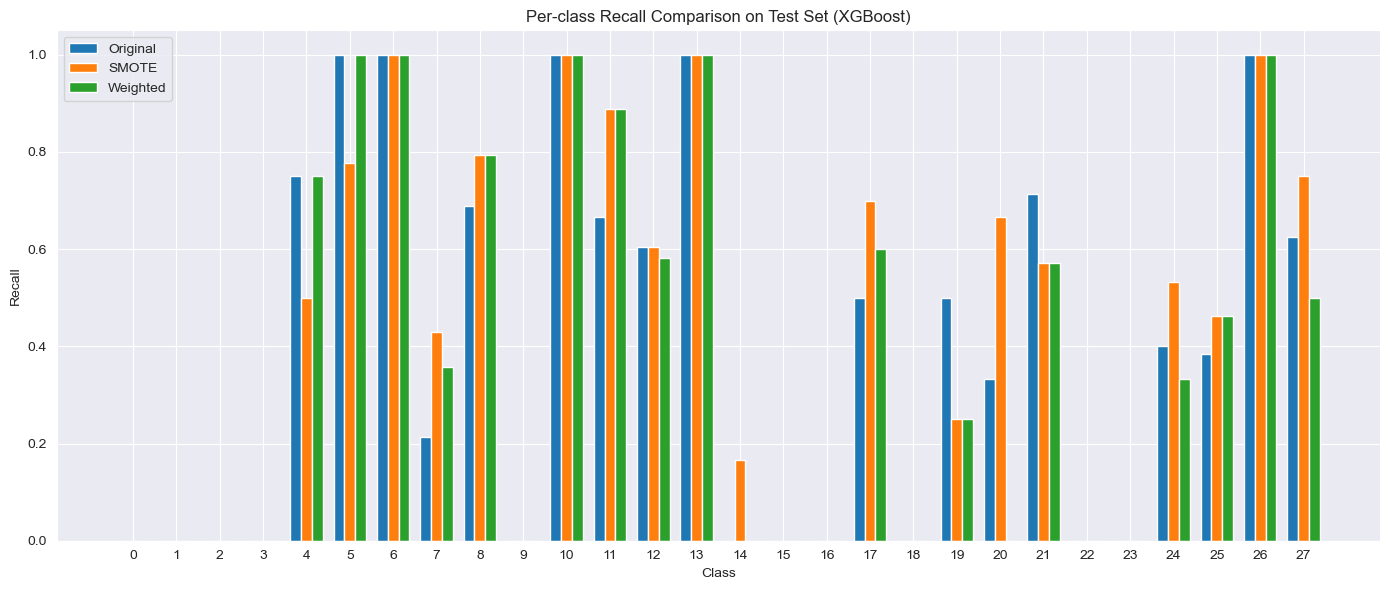

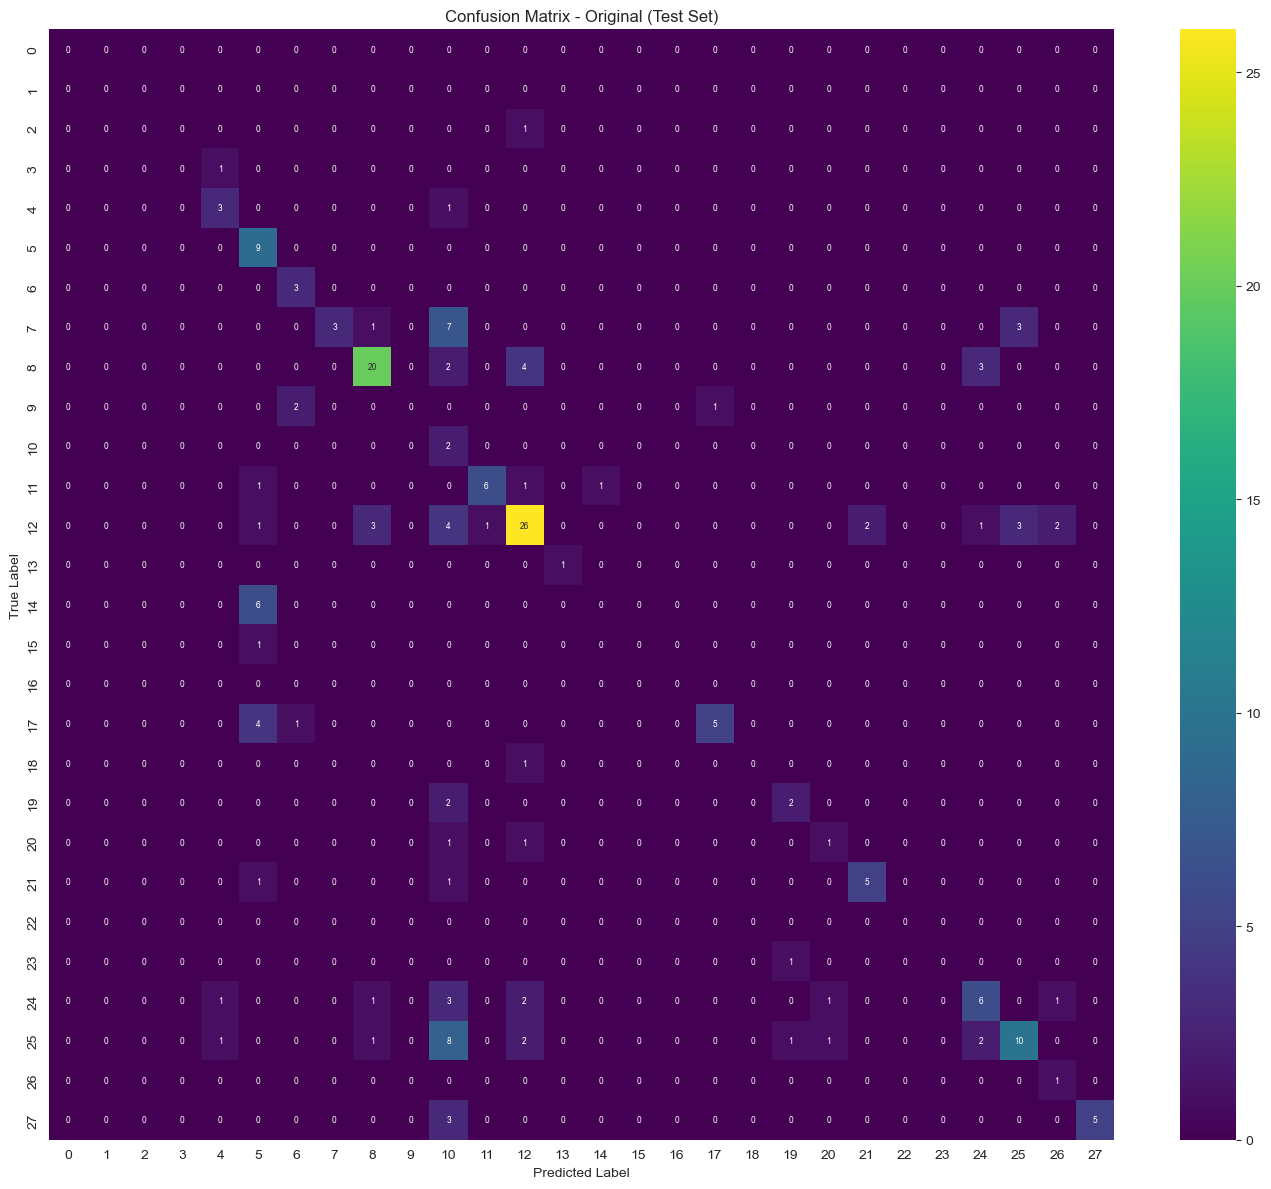

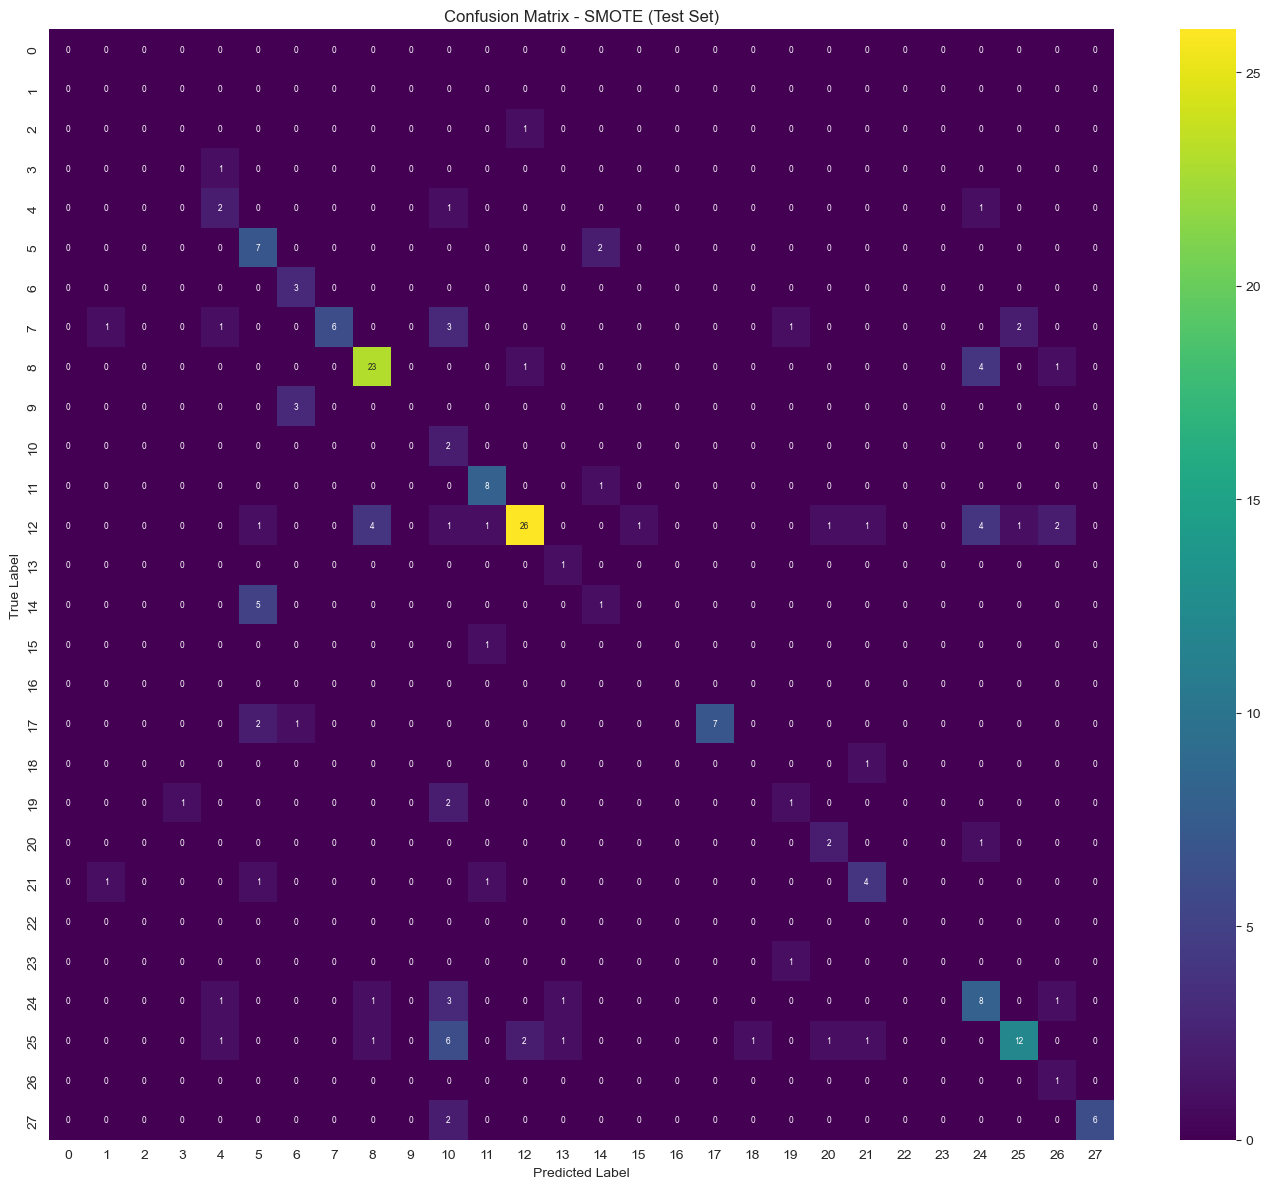

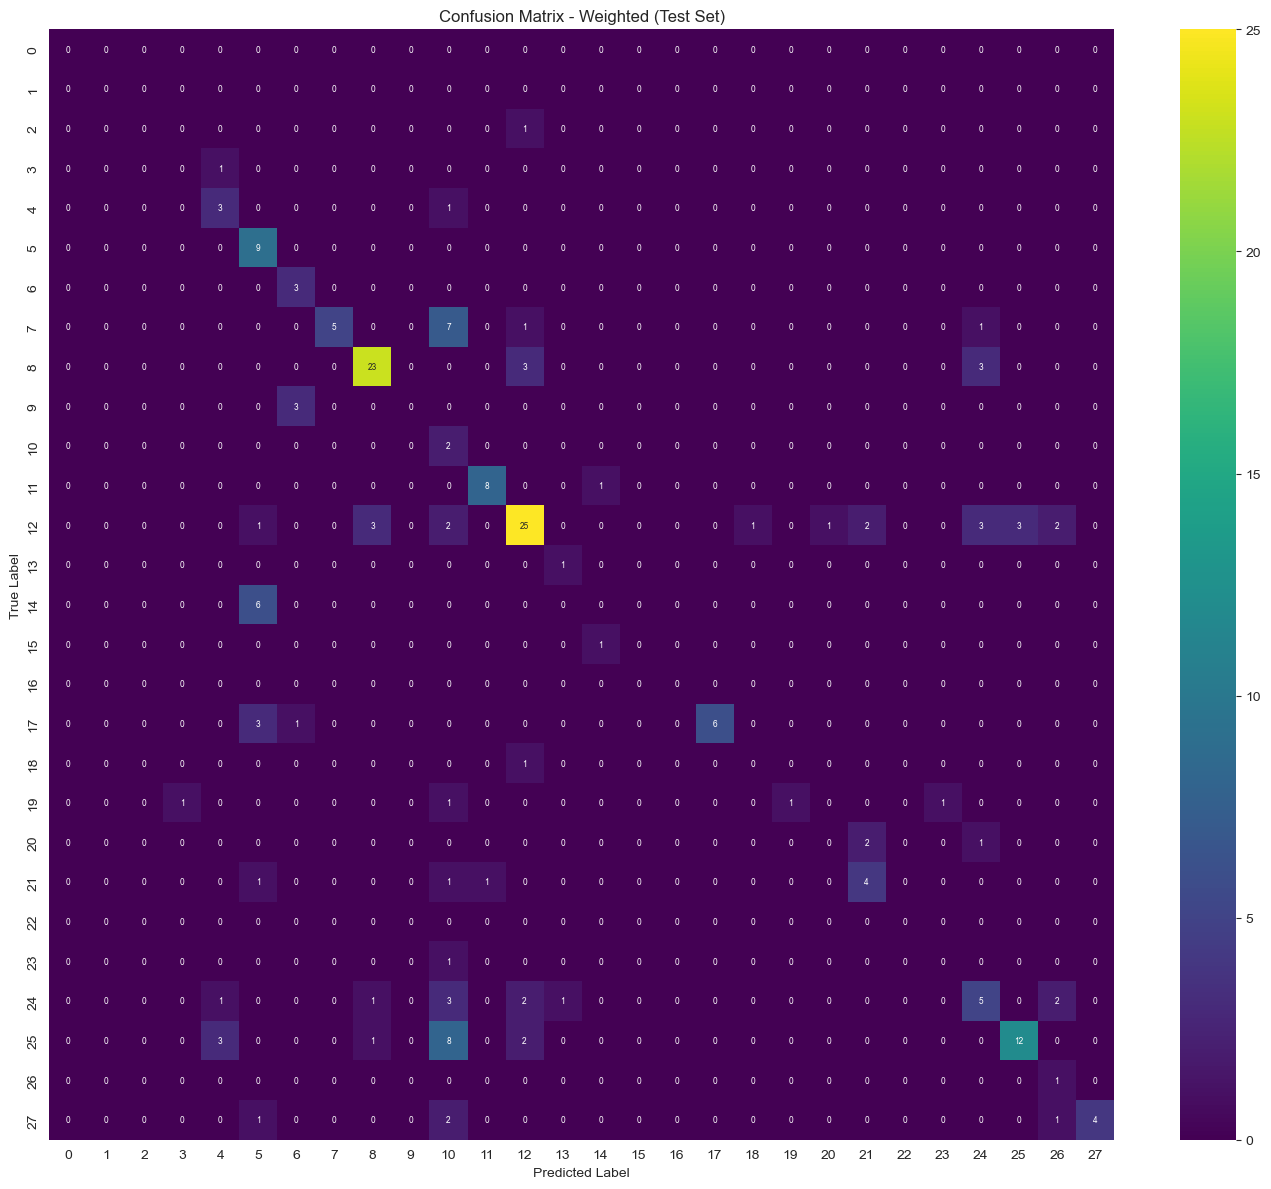

    Class  Original     SMOTE  Weighted
0       0  0.000000  0.000000  0.000000
1       1  0.000000  0.000000  0.000000
2       2  0.000000  0.000000  0.000000
3       3  0.000000  0.000000  0.000000
4       4  0.750000  0.500000  0.750000
5       5  1.000000  0.777778  1.000000
6       6  1.000000  1.000000  1.000000
7       7  0.214286  0.428571  0.357143
8       8  0.689655  0.793103  0.793103
9       9  0.000000  0.000000  0.000000
10     10  1.000000  1.000000  1.000000
11     11  0.666667  0.888889  0.888889
12     12  0.604651  0.604651  0.581395
13     13  1.000000  1.000000  1.000000
14     14  0.000000  0.166667  0.000000
15     15  0.000000  0.000000  0.000000
16     16  0.000000  0.000000  0.000000
17     17  0.500000  0.700000  0.600000
18     18  0.000000  0.000000  0.000000
19     19  0.500000  0.250000  0.250000
20     20  0.333333  0.666667  0.000000
21     21  0.714286  0.571429  0.571429
22     22  0.000000  0.000000  0.000000
23     23  0.000000  0.000000  0.000000


In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

X_train_all = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y_train_raw = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
X_test_all = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).values[:202]
y_test_raw = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()

# 标签编码
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# 使用 Top 100 特征
final_features = feat_merged.sort_values(by="rank_avg")["feature_idx"].head(100).astype(int).tolist()
X_train = X_train_all[:, final_features]
X_test = X_test_all[:, final_features]

# 标准化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 模型训练与预测
results = {}

# A. 原始数据训练
model_a = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_a.fit(X_train_std, y_train)
y_pred_a = model_a.predict(X_test_std)
results["A.Original"] = f1_score(y_test, y_pred_a, average="weighted")

# B. SMOTE
min_samples = np.min(np.bincount(y_train))
k = max(1, min(min_samples - 1, 5))
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_train_std, y_train)
model_b = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_b.fit(X_smote, y_smote)
y_pred_b = model_b.predict(X_test_std)
results["B.SMOTE"] = f1_score(y_test, y_pred_b, average="weighted")

# C. 类权重
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))
sample_weights = np.array([class_weights[label] for label in y_train])
model_c = XGBClassifier(objective="multi:softprob", num_class=28,
                        eval_metric="mlogloss", use_label_encoder=False, random_state=42)
model_c.fit(X_train_std, y_train, sample_weight=sample_weights)
y_pred_c = model_c.predict(X_test_std)
results["C.Weighted"] = f1_score(y_test, y_pred_c, average="weighted")

# Per-class Recall
recall_df_test = pd.DataFrame({
    "Class": np.arange(28),
    "Original": recall_score(y_test, y_pred_a, average=None, labels=np.arange(28), zero_division=0),
    "SMOTE": recall_score(y_test, y_pred_b, average=None, labels=np.arange(28), zero_division=0),
    "Weighted": recall_score(y_test, y_pred_c, average=None, labels=np.arange(28), zero_division=0),
})

plt.figure(figsize=(14, 6))
x = np.arange(len(recall_df_test))
width = 0.25
plt.bar(x - width, recall_df_test["Original"], width=width, label="Original")
plt.bar(x, recall_df_test["SMOTE"], width=width, label="SMOTE")
plt.bar(x + width, recall_df_test["Weighted"], width=width, label="Weighted")
plt.xticks(ticks=x, labels=recall_df_test["Class"])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Per-class Recall Comparison on Test Set (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

plot_conf_matrix("Confusion Matrix - Original (Test Set)", y_test, y_pred_a)
plot_conf_matrix("Confusion Matrix - SMOTE (Test Set)", y_test, y_pred_b)
plot_conf_matrix("Confusion Matrix - Weighted (Test Set)", y_test, y_pred_c)

report_original = classification_report(y_test, y_pred_a, output_dict=True, zero_division=0)
report_smote = classification_report(y_test, y_pred_b, output_dict=True, zero_division=0)
report_weighted = classification_report(y_test, y_pred_c, output_dict=True, zero_division=0)

df_report_original = pd.DataFrame(report_original).transpose()
df_report_smote = pd.DataFrame(report_smote).transpose()
df_report_weighted = pd.DataFrame(report_weighted).transpose()

print(recall_df_test)
print(results)


## 为什么accuracy指标 不适合 用于类别不均衡场景问题 有什么更合适的评价指标

 类别分布严重不平衡的多分类问题中，传统的准确率（Accuracy）指标往往无法真实反映模型性能。例如，当训练数据中某一主类占比达到 95% 时，模型即便始终预测为该主类，也可轻松获得 95% 的准确率。然而，此时模型对其他 27 个类别完全没有学习能力。因此，仅使用准确率作为评估标准，会对模型在少数类上的表现产生误导性判断。

为更全面地评估模型性能，尤其是其对少数类的识别能力，我们将采用以下更优的评价指标：

- **Precision（精确率）**：用于衡量模型在预测为某类时的正确率。它反映了误报（False Positives）情况，特别适合对错误预测代价较高的场景。
  
- **Recall（召回率）**：衡量模型在实际属于某类的样本中被成功识别出来的比例，强调覆盖性。对于少数类识别能力的评估尤为关键。
  
- **F1-score**：精确率与召回率的调和平均值，兼顾“预测准确性”与“检测全面性”，在精确率和召回率存在权衡时能提供更稳定的评价。
  
- **AUC-ROC / AUC-PR 曲线面积**：从概率输出角度评价模型的排序能力。特别是 AUC-PR，在正负样本比例极度失衡时更为敏感，是对少数类预测质量的补充评估手段。
  
- **Confusion Matrix（混淆矩阵）**：直观展示模型在各类别上的预测正确率与混淆情况，有助于发现模型在哪些具体类别上存在识别偏差。

此外，我们将会使用不同的聚合方式：
- `macro` 平均对每个类别赋予相同权重，反映模型在所有类别上的“公平性”；
- `weighted` 平均根据类别样本数加权，更能代表模型整体预测性能。
